In [1]:
!pip install --upgrade scanpy
!pip install --upgrade pandas
!pip install --ignore-installed llvmlite
!pip install squidpy

     |████████████████████████████████| 2.0 MB 29.4 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 14.0 MB/s  eta 0:00:01
     |████████████████████████████████| 102 kB 131.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 128.6 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 4.0 MB/s s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=0c2e8b2c2fdb0e386d42b83fdc44a326d9471739b498db0cffdf08e256d90948
  Stored in directory: /home/jovyan/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55639 sha256=62aa2d35b72b19188510380deb1d60ff38eb1f6da620a7842977ba69393a0883
  Stored in directory: /home/jovyan/.cache/pip/wheels/12/f9/4d/ec5ad1c823c710fcc4473669fdcffc8891f4bc398c841af22e
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8045 sha256=9a21b0bd12

In [2]:
import numpy as np
import pandas as pd
import scanpy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output
import squidpy as sq
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
import pickle

In [4]:
# Load Mouse embryo data
adata = sp.read_h5ad('E9.5_E1S1.MOSTA.h5ad')
print(adata.shape)

(5913, 25568)


In [3]:
# Load Mouse brain data
adata = sp.read_h5ad('Mouse_brain_cell_bin.h5ad')
print(adata.shape)

(50140, 25879)


In [6]:
# Preprocessing for Mouse embryo data
sp.pp.filter_cells(adata, min_genes = np.percentile(adata.obs['n_genes_by_counts'], 5))
sp.pp.filter_genes(adata, min_cells=30)
print('Filtered genes')

sp.pp.normalize_total(adata, inplace=True)
print('Normalized')

sp.pp.log1p(adata)
print('logd')

Filtered genes
Normalized
logd


In [5]:
# Preprocessing for Mouse brain data
sp.pp.filter_genes(adata, min_cells=30)
print('Filtered genes')

sp.pp.normalize_total(adata, inplace=True)
print('Normalized')

sp.pp.log1p(adata)
print('logd')

Filtered genes
Normalized
logd


In [6]:
# Moran’s I score in Squidpy
sq.gr.spatial_neighbors(adata)
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names)

In [7]:
adata.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
Plp1,0.497515,0.000000,0.000007,0.000000
Th,0.452704,0.000000,0.000007,0.000000
Mbp,0.450572,0.000000,0.000007,0.000000
Slc6a3,0.443204,0.000000,0.000007,0.000000
Hba-a1,0.390274,0.000000,0.000007,0.000000
...,...,...,...,...
Limk2,-0.005895,0.011101,0.000007,0.034168
Mecp2,-0.006021,0.009745,0.000007,0.030494
Arih1,-0.006281,0.007407,0.000007,0.023977
Slc52a2,-0.006636,0.005011,0.000007,0.016981


In [23]:
# identify genes with significant spatial autocorrelation
alpha = 1e-11 # set significance level 1e-16 for Mouse embryo, 1e-11 for Mouse brain
is_svg = adata.uns["moranI"].pval_norm_fdr_bh < alpha
n_svg = sum(is_svg)
print(n_svg)

SVGs = adata.uns['moranI'][is_svg].axes[0].tolist()

1951


Comparing results with SpaGFT

In [17]:
with open('SVG_SpaGFT_embryo', 'rb') as f:
    svg_spagft = pickle.load(f)

In [9]:
with open('SVG_SpaGFT_brain', 'rb') as f:
    svg_spagft = pickle.load(f)

Confusion matrix: 
 [[14946   780]
 [  629  1171]]
F1 score:  0.6243668355105305
AUC: 0.8004780830047904


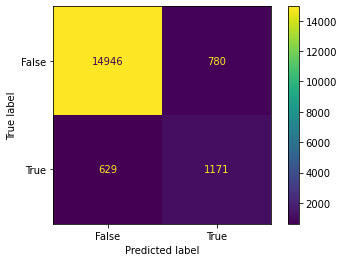

In [24]:
set1 = set(svg_spagft) 
set2 = set(SVGs)

true_labels = [gene in set1 for gene in adata.var_names]
preds = [gene in set2 for gene in adata.var_names]

cm = confusion_matrix(true_labels, preds)
f1 = f1_score(true_labels, preds)
auc = roc_auc_score(true_labels, preds)
print('Confusion matrix: \n', cm)
print('F1 score: ', f1)
print('AUC:', auc)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

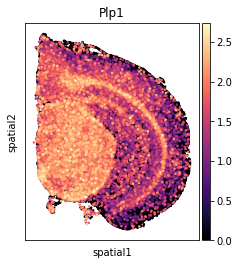

In [26]:
plot_svgs = ['Plp1']
sp.pl.spatial(adata, color=plot_svgs, size=1.6, cmap='magma', use_raw=False, spot_size=100)